# Initial Data EDA

In [42]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# Load modules
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.layers import Dense
from keras.models import Sequential
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
# Project modules
import get_modeling_data
import model_evaluation.model_performance_functions as mpf
import features.win_rates as wr
import data_constants as dc
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.ensemble

Using TensorFlow backend.


In [2]:
data = pd.read_csv(os.getenv('MINED_DATA_DIR') + 'processed_match_data.csv')
print("Number of rows: " + str(data.shape[0]))
print("Number of columns: " + str(data.shape[1]))
pd.set_option('display.max_columns', 200)
data.head()

Number of rows: 285536
Number of columns: 15


,match_id,game_version,queue_id,game_duration,team_100_win,100_TOP_SOLO,100_JUNGLE_NONE,100_MIDDLE_SOLO,100_BOTTOM_DUO_CARRY,100_BOTTOM_DUO_SUPPORT,200_TOP_SOLO,200_JUNGLE_NONE,200_MIDDLE_SOLO,200_BOTTOM_DUO_CARRY,200_BOTTOM_DUO_SUPPORT
0,2726806213,8.4.218.8787,420,1452,0,Kled,Reng,Kata,Varu,Tari,Akal,Vi,Dr.,Vayn,Lulu
1,2726789592,8.4.218.8787,420,1539,0,Rene,Mast,Fizz,Cait,Lux,Kled,Skar,Kass,Ezre,Sona
2,2726784050,8.4.218.8787,420,1380,0,Kled,Reng,Ryze,Varu,Sora,Gang,Seju,Ahri,Jinx,Blit
3,2726032902,8.4.218.8787,420,1360,1,Kled,Kayn,Fizz,Varu,Tari,Blit,Shac,Kayl,Tris,Lux
4,2726003824,8.4.218.8787,420,1773,1,Kled,Lee,Aniv,Drav,Bard,Yasu,Reng,Ekko,Tris,Tahm


#### Number of Unique Champions

In [3]:
data['100_TOP_SOLO'].nunique()

141

#### Distribution of blue side wins vs. red side wins

In [4]:
data['team_100_win'].value_counts() / data.shape[0]

0    0.505814
1    0.494186
Name: team_100_win, dtype: float64

#### Champions are usually only picked in 1 or 2 positions

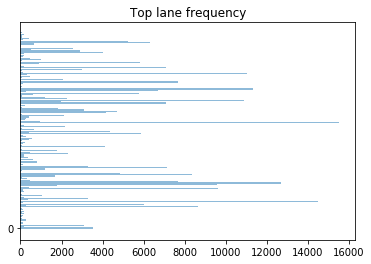

In [5]:
top_lane_freq = data['100_TOP_SOLO'].value_counts()
plt.barh(top_lane_freq.index, top_lane_freq, align='center', alpha=0.5)
plt.title('Top lane frequency')
plt.yticks('')
plt.show()

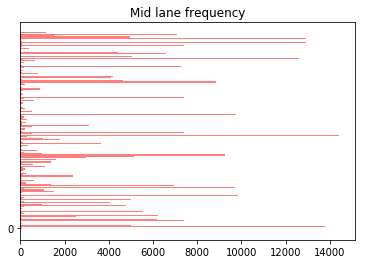

In [6]:
mid_lane_freq = data['100_MIDDLE_SOLO'].value_counts()
plt.barh(mid_lane_freq.index, mid_lane_freq, align='center', alpha=0.5, color='red')
plt.yticks('')
plt.title('Mid lane frequency')
plt.show()

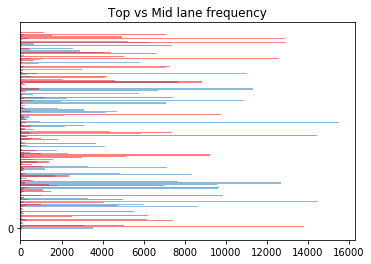

In [7]:
top_lane_freq = data['100_TOP_SOLO'].value_counts()
plt.barh(top_lane_freq.index, top_lane_freq, align='center', alpha=0.5)
mid_lane_freq = data['100_MIDDLE_SOLO'].value_counts()
plt.barh(mid_lane_freq.index, mid_lane_freq, align='center', alpha=0.5, color='red')
plt.title('Top vs Mid lane frequency')
plt.yticks('')
plt.show()

In [8]:
win_rates = pd.read_csv('../data/win_rates/all_champ_all_lanes_win_rates.csv', index_col=0)
win_rates.head()

,TOP_SOLO_win_rate,TOP_SOLO_games_played,MIDDLE_SOLO_win_rate,MIDDLE_SOLO_games_played,BOTTOM_DUO_CARRY_win_rate,BOTTOM_DUO_CARRY_games_played,BOTTOM_DUO_SUPPORT_win_rate,BOTTOM_DUO_SUPPORT_games_played,JUNGLE_NONE_win_rate,JUNGLE_NONE_games_played
Aatr,0.501899,4212.0,0.523364,107.0,0.588235,17.0,0.488372,43.0,0.516491,1425.0
Ahri,0.556818,176.0,0.501790,16479.0,0.480000,100.0,0.535948,153.0,0.571429,7.0
Akal,0.498500,3667.0,0.502720,5882.0,0.250000,16.0,0.580645,31.0,0.537313,268.0
Alis,0.532544,169.0,0.569620,79.0,0.500000,20.0,0.505727,15540.0,0.568421,95.0
Amum,0.543624,149.0,0.611111,36.0,0.500000,2.0,0.435583,163.0,0.502213,6101.0


## 10 Categorical Variables w/ 141 levels each, predicting a 0-1 indicator
#### Let's do a train-valid-test split and try a basic logistic model

In [9]:
# Separate into training, validation, and test
train = get_modeling_data.get_train()
valid = get_modeling_data.get_validation()
train = sm.add_constant(train)
valid = sm.add_constant(valid)

In [10]:
# Basic Logistic model
#formula = 'team_100_win ~ C(BLUE_TOP_SOLO) + C(BLUE_MIDDLE_SOLO) + C(BLUE_JUNGLE_NONE) + C(BLUE_BOTTOM_DUO_CARRY) + C(BLUE_BOTTOM_DUO_SUPPORT)'
#######################
#### DONT RUN THIS ####
#######################
#basic_logistic = smf.glm(formula=formula, data=train, family=sm.families.Binomial()).fit()

### Lesson 0: GLM won't take variables with leading numbers in the name
### Lesson 1: GLM hot encodes categorical variables, blows up the memory requirement.

# Let's try a basic encoding
### - Replacing champions in each lane with their respective win rate
### - Basic logistic model

In [11]:
lane_cols = ['100_TOP_SOLO', '100_MIDDLE_SOLO', '100_JUNGLE_NONE', '100_BOTTOM_DUO_CARRY',
 '100_BOTTOM_DUO_SUPPORT', '200_TOP_SOLO', '200_MIDDLE_SOLO', '200_JUNGLE_NONE',
 '200_BOTTOM_DUO_CARRY', '200_BOTTOM_DUO_SUPPORT']

lane_cols_color = ['BLUE_TOP_SOLO', 'BLUE_MIDDLE_SOLO', 'BLUE_JUNGLE_NONE', 'BLUE_BOTTOM_DUO_CARRY',
 'BLUE_BOTTOM_DUO_SUPPORT', 'RED_TOP_SOLO', 'RED_MIDDLE_SOLO', 'RED_JUNGLE_NONE',
 'RED_BOTTOM_DUO_CARRY', 'RED_BOTTOM_DUO_SUPPORT']

lane_cols_wr = [x + '_wr' for x in lane_cols]
lane_cols_wr_color = [x + '_wr' for x in lane_cols_color]

lane_cols_wr_dict = dict(zip(lane_cols_wr, lane_cols_wr_color))

train_wr = train.rename(lane_cols_wr_dict, axis=1)
train_wr = train_wr[lane_cols_wr_color + ['team_100_win']]
valid_wr = valid.rename(lane_cols_wr_dict, axis=1)
valid_wr = valid_wr[lane_cols_wr_color + ['team_100_win']]

In [12]:
# Basic Logistic model
wr_formula = 'team_100_win ~ ' +  ' + '.join(lane_cols_wr_color)
basic_logistic = smf.glm(formula=wr_formula, data=train_wr, family=sm.families.Binomial()).fit()
basic_logistic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           team_100_win   No. Observations:               171284
Model:                            GLM   Df Residuals:                   171273
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.1833e+05
Date:                Thu, 09 Aug 2018   Deviance:                   2.3666e+05
Time:                        21:22:28   Pearson chi2:                 1.71e+05
No. Iterations:                     4                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     20.8230      0.799     26.057      0.000      19.257      22.389
BLUE_TOP_SOLO_wr              -3.2932      0.449     -7.330      0.000      -4.174      -2.413
BLUE_MIDDLE_SOLO_wr           -4.6459      0.463    -10.032      0.000      -5.554      -3.738
BLUE_JUNGLE_NONE_wr           -4.3828      0.546     -8.032      0.000      -5.452      -3.313
BLUE_BOTTOM_DUO_CARRY_wr      -4.9691      0.549     -9.048      0.000      -6.046      -3.893
BLUE_BOTTOM_DUO_SUPPORT_wr    -5.6689      0.464    -12.226      0.000      -6.578      -4.760
RED_TOP_SOLO_wr               -4.8969      0.465    -10.541      0.000      -5.807      -3.986
RED_MIDDLE_SOLO_wr            -3.5145      0.469     -7.498      0.000      -4.433      -2.596
RED_JUNGLE_NONE_wr            -3.8803      0.547     -7.090      0.000      -4.953      -2.808
RED_BOTTOM_DUO_CARRY_wr       -3.5112      0.538     -6.529      0.000      -4.565      -2.457
RED_BOTTOM_DUO_SUPPORT_wr     -2.4565      0.457     -5.372      0.000      -3.353      -1.560
==============================================================================================
"""

In [13]:
train_pred = basic_logistic.predict(train_wr)
valid_pred = basic_logistic.predict(valid_wr)

{'threshold': 0.5, 'accuracy': 0.5231953947829336}
{'threshold': 0.79, 'accuracy': 0.5080482721174224}


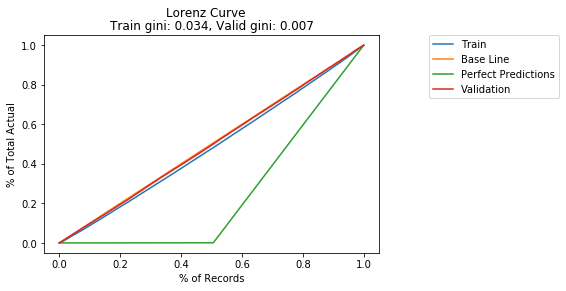

In [14]:
print(mpf.best_threshold(train_wr['team_100_win'], train_pred))
print(mpf.best_threshold(valid_wr['team_100_win'], valid_pred))
mpf.lorenz_curve(train_wr['team_100_win'], train_pred, valid_wr['team_100_win'], valid_pred)

### Lesson 2: Win rates are leaking information about match outcomes

# A Journey of Different Models
#### 1. Encoding paired win rates and head to head win rates
#### 2. Champ classes
#### 3. Word2Vec Encoding
#### 4. Non-positional hot encoding
#### 5. Ensembles

# 1. Paired Win Rates

In [15]:
paired_wr_cols = dc.get_lane_pair_cols()
display(train[sorted(paired_wr_cols)].head())

,100_BOTTOM_DUO_CARRY_BOTTOM_DUO_SUPPORT_gp,100_BOTTOM_DUO_CARRY_BOTTOM_DUO_SUPPORT_wr,100_BOTTOM_DUO_CARRY_JUNGLE_NONE_gp,100_BOTTOM_DUO_CARRY_JUNGLE_NONE_wr,100_BOTTOM_DUO_SUPPORT_JUNGLE_NONE_gp,100_BOTTOM_DUO_SUPPORT_JUNGLE_NONE_wr,100_MIDDLE_SOLO_BOTTOM_DUO_CARRY_gp,100_MIDDLE_SOLO_BOTTOM_DUO_CARRY_wr,100_MIDDLE_SOLO_BOTTOM_DUO_SUPPORT_gp,100_MIDDLE_SOLO_BOTTOM_DUO_SUPPORT_wr,100_MIDDLE_SOLO_JUNGLE_NONE_gp,100_MIDDLE_SOLO_JUNGLE_NONE_wr,100_TOP_SOLO_BOTTOM_DUO_CARRY_gp,100_TOP_SOLO_BOTTOM_DUO_CARRY_wr,100_TOP_SOLO_BOTTOM_DUO_SUPPORT_gp,100_TOP_SOLO_BOTTOM_DUO_SUPPORT_wr,100_TOP_SOLO_JUNGLE_NONE_gp,100_TOP_SOLO_JUNGLE_NONE_wr,100_TOP_SOLO_MIDDLE_SOLO_gp,100_TOP_SOLO_MIDDLE_SOLO_wr,200_BOTTOM_DUO_CARRY_BOTTOM_DUO_SUPPORT_gp,200_BOTTOM_DUO_CARRY_BOTTOM_DUO_SUPPORT_wr,200_BOTTOM_DUO_CARRY_JUNGLE_NONE_gp,200_BOTTOM_DUO_CARRY_JUNGLE_NONE_wr,200_BOTTOM_DUO_SUPPORT_JUNGLE_NONE_gp,200_BOTTOM_DUO_SUPPORT_JUNGLE_NONE_wr,200_MIDDLE_SOLO_BOTTOM_DUO_CARRY_gp,200_MIDDLE_SOLO_BOTTOM_DUO_CARRY_wr,200_MIDDLE_SOLO_BOTTOM_DUO_SUPPORT_gp,200_MIDDLE_SOLO_BOTTOM_DUO_SUPPORT_wr,200_MIDDLE_SOLO_JUNGLE_NONE_gp,200_MIDDLE_SOLO_JUNGLE_NONE_wr,200_TOP_SOLO_BOTTOM_DUO_CARRY_gp,200_TOP_SOLO_BOTTOM_DUO_CARRY_wr,200_TOP_SOLO_BOTTOM_DUO_SUPPORT_gp,200_TOP_SOLO_BOTTOM_DUO_SUPPORT_wr,200_TOP_SOLO_JUNGLE_NONE_gp,200_TOP_SOLO_JUNGLE_NONE_wr,200_TOP_SOLO_MIDDLE_SOLO_gp,200_TOP_SOLO_MIDDLE_SOLO_wr
1,980.0,0.504082,1492.0,0.518097,553.0,0.475588,1137.0,0.525945,354.0,0.497175,640.0,0.557813,790.0,0.462025,255.0,0.450980,433.0,0.512702,337.0,0.516320,1204.0,0.507475,737.0,0.506106,324.0,0.527778,521.0,0.466411,239.0,0.535565,158.0,0.525316,407.0,0.471744,189.0,0.613757,141.0,0.567376,89.0,0.393258
2,897.0,0.547380,1017.0,0.497542,493.0,0.511156,648.0,0.462963,348.0,0.445402,370.0,0.424324,344.0,0.517442,188.0,0.505319,204.0,0.431373,161.0,0.459627,1461.0,0.516085,987.0,0.512665,562.0,0.500000,1293.0,0.533643,762.0,0.526247,557.0,0.520646,871.0,0.508611,584.0,0.517123,466.0,0.508584,535.0,0.527103
5,2192.0,0.494526,93.0,0.494624,62.0,0.516129,899.0,0.489433,889.0,0.466817,40.0,0.475000,109.0,0.385321,131.0,0.442748,5.0,0.200000,45.0,0.466667,1281.0,0.512881,349.0,0.489971,100.0,0.610000,983.0,0.510682,347.0,0.515850,71.0,0.507042,518.0,0.521236,189.0,0.619048,55.0,0.436364,119.0,0.554622
6,323.0,0.489164,885.0,0.470056,172.0,0.441860,647.0,0.539413,124.0,0.524194,341.0,0.439883,50.0,0.560000,13.0,0.615385,23.0,0.478261,19.0,0.736842,1053.0,0.554606,136.0,0.485294,104.0,0.413462,8.0,0.750000,5.0,0.800000,3.0,0.333333,252.0,0.432540,182.0,0.450549,25.0,0.480000,2.0,0.000000
7,1276.0,0.509404,1712.0,0.519860,561.0,0.565062,952.0,0.489496,286.0,0.503497,446.0,0.526906,518.0,0.519305,121.0,0.545455,221.0,0.538462,139.0,0.424460,7120.0,0.512640,433.0,0.443418,243.0,0.465021,1202.0,0.500832,655.0,0.509924,308.0,0.418831,261.0,0.444444,157.0,0.433121,53.0,0.452830,145.0,0.434483


#### Random Forest on Paired Win Rates

In [16]:
train_paired_wr = train[paired_wr_cols + ['team_100_win']]
valid_paired_wr = valid[paired_wr_cols + ['team_100_win']]

rf_params = { 'max_features': 'sqrt',
              'n_estimators': 300,
              'min_samples_split': 1000,
              'min_samples_leaf': 500,
              'max_depth': 3,
              'random_state': 414}
rf_model = sklearn.ensemble.RandomForestRegressor(**rf_params)
rf_model_fit = rf_model.fit(train_paired_wr.drop(['team_100_win'], axis=1), train_paired_wr['team_100_win'])

Train Gini: {'ks': 0.0852788588604051, 'gini': 0.11919430022444445}
Train accuracy: {'threshold': 0.49, 'accuracy': 0.5811517713271526}
Validation Gini: {'ks': 0.04995667873594817, 'gini': 0.06954021706068993}
Validation accuracy: {'threshold': 0.5, 'accuracy': 0.5465818927013819}


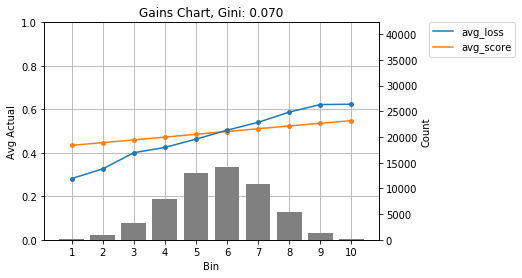

,bin,count,avg_score,avg_loss
1,1,135.0,0.434461,0.281481
2,2,843.0,0.446943,0.326216
3,3,3336.0,0.459450,0.400480
4,4,8013.0,0.472313,0.424810
5,5,13008.0,0.485150,0.462869
6,6,14099.0,0.497960,0.504149
7,7,10843.0,0.510789,0.539980
8,8,5394.0,0.523576,0.587134
9,9,1336.0,0.535777,0.622006
10,10,85.0,0.547822,0.623529


In [17]:
train_pred_rf = rf_model_fit.predict(train_paired_wr.drop(['team_100_win'], axis=1))
valid_pred_rf = rf_model_fit.predict(valid_paired_wr.drop(['team_100_win'], axis=1))
print("Train Gini: " + str(mpf.ks_gini(train_paired_wr['team_100_win'], train_pred_rf)))
print("Train accuracy: " + str(mpf.best_threshold(train_paired_wr['team_100_win'], train_pred_rf)))
print("Validation Gini: " + str(mpf.ks_gini(valid_paired_wr['team_100_win'], valid_pred_rf)))
print("Validation accuracy: " + str(mpf.best_threshold(valid_paired_wr['team_100_win'], valid_pred_rf)))
mpf.gains_chart(valid_paired_wr['team_100_win'], valid_pred_rf)

### Penalize win rates with low statistical significance 

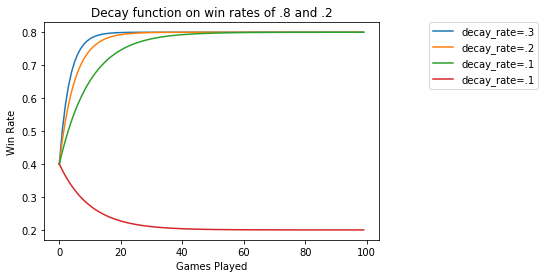

In [18]:
plt.plot(np.arange(100), wr.decayed_win_rate(win_rate=.8 * np.ones(100), games_played=np.arange(100), 
                                             decay_speed=.3), label='decay_rate=.3')
plt.plot(np.arange(100), wr.decayed_win_rate(win_rate=.8 * np.ones(100), games_played=np.arange(100),
                                             decay_speed=.2), label='decay_rate=.2')
plt.plot(np.arange(100), wr.decayed_win_rate(win_rate=.8 * np.ones(100), games_played=np.arange(100), 
                                             decay_speed=.1), label='decay_rate=.1')
plt.plot(np.arange(100), wr.decayed_win_rate(win_rate=.2 * np.ones(100), games_played=np.arange(100), 
                                             decay_speed=.1), label='decay_rate=.1')
plt.xlabel('Games Played')
plt.ylabel('Win Rate')
plt.title('Decay function on win rates of .8 and .2')
plt.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
plt.show()

$Decay(gp, wr) = wr \cdot (1 - exp(-(gp))) + .4 exp(-gp)$

In [19]:
train_decayed_wr = train[:]
valid_decayed_wr = valid[:]
for col in paired_wr_cols:
    train_decayed_wr[col] = wr.decayed_win_rate(train_decayed_wr[col], 
                                                train_decayed_wr[col[0:-2] + 'gp'], 
                                                decay_speed=.1)
    valid_decayed_wr[col] = wr.decayed_win_rate(valid_decayed_wr[col], 
                                                valid_decayed_wr[col[0:-2] + 'gp'], 
                                                decay_speed=.1)

train_decayed_wr = train_decayed_wr[paired_wr_cols + ['team_100_win']]
valid_decayed_wr = valid_decayed_wr[paired_wr_cols + ['team_100_win']]

In [20]:
rf2_params = { 'max_features': 'sqrt',
              'n_estimators': 300,
              'min_samples_split': 1000,
              'min_samples_leaf': 500,
              'max_depth': 3,
              'random_state': 414}
rf2_model = sklearn.ensemble.RandomForestRegressor(**rf2_params)
rf2_model_fit = rf2_model.fit(train_decayed_wr.drop(['team_100_win'], axis=1), train_decayed_wr['team_100_win'])

Train Gini: {'ks': 0.0836205057654959, 'gini': 0.11720181495059621}
Train accuracy: {'threshold': 0.5, 'accuracy': 0.5804044744401111}
Validation Gini: {'ks': 0.04957600383506355, 'gini': 0.06986931329712774}
Validation accuracy: {'threshold': 0.5, 'accuracy': 0.5478254777293188}


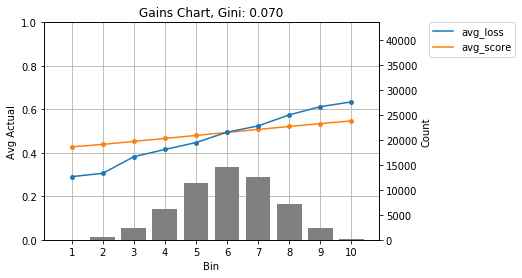

In [21]:
train_pred_rf2 = rf2_model_fit.predict(train_decayed_wr.drop(['team_100_win'], axis=1))
valid_pred_rf2 = rf2_model_fit.predict(valid_decayed_wr.drop(['team_100_win'], axis=1))
print("Train Gini: " + str(mpf.ks_gini(train_decayed_wr['team_100_win'], train_pred_rf2)))
print("Train accuracy: " + str(mpf.best_threshold(train_decayed_wr['team_100_win'], train_pred_rf2)))
print("Validation Gini: " + str(mpf.ks_gini(valid_decayed_wr['team_100_win'], valid_pred_rf2)))
print("Validation accuracy: " + str(mpf.best_threshold(valid_decayed_wr['team_100_win'], valid_pred_rf2)))
mpf.gains_chart(valid_decayed_wr['team_100_win'], valid_pred_rf2, return_table=False)

### Lesson 3: All because it's the "right" thing to do, doesn't mean it'll improve performance

# 2. Champ Classes
Champions usually fulfill a certain "role" on the team.  Eg. 'Tanks' are champions that are difficult to take down, but don't usually output much damage.  'Mages' are easy to take down, but they have lots of power in the spells they cast.

In [22]:
champ_classes = pd.read_csv('../data/interim/champ_classes.csv', index_col=0)
champ_classes.head()

,Controller,Catcher,Enchanter,Fighter,Diver,Juggernaut,Mages,Artillery,Battlemage,Burst,Marksman,Slayer,Assassin,Skirmisher,Tank,Vanguard,Warden,Specialist
Aatr,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Ahri,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
Akal,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
Alis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
Amum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [23]:
train_cc = train[lane_cols + ['team_100_win']]
valid_cc = valid[lane_cols + ['team_100_win']]

for col in champ_classes.columns:
    train_cc['100_' + col + '_cnt'] = 0
    train_cc['200_' + col + '_cnt'] = 0
    valid_cc['100_' + col + '_cnt'] = 0
    valid_cc['200_' + col + '_cnt'] = 0
    
team_100_cols = ['100_TOP_SOLO', '100_MIDDLE_SOLO', '100_JUNGLE_NONE', '100_BOTTOM_DUO_CARRY', '100_BOTTOM_DUO_SUPPORT']
for lane_col in team_100_cols:
    train_cc = pd.merge(train_cc, champ_classes, how='left', left_on=lane_col, right_index=True)
    valid_cc = pd.merge(valid_cc, champ_classes, how='left', left_on=lane_col, right_index=True)
    for col in champ_classes.columns:
        train_cc['100_' + col + '_cnt'] = train_cc['100_' + col + '_cnt'] + train_cc[col]
        train_cc.drop([col], inplace=True, axis=1)
        valid_cc['100_' + col + '_cnt'] = valid_cc['100_' + col + '_cnt'] + valid_cc[col]
        valid_cc.drop([col], inplace=True, axis=1)

team_200_cols = ['200_TOP_SOLO', '200_MIDDLE_SOLO', '200_JUNGLE_NONE', '200_BOTTOM_DUO_CARRY', '200_BOTTOM_DUO_SUPPORT']
for lane_col in team_200_cols:
    train_cc = pd.merge(train_cc, champ_classes, how='left', left_on=lane_col, right_index=True)
    valid_cc = pd.merge(valid_cc, champ_classes, how='left', left_on=lane_col, right_index=True)
    for col in champ_classes.columns:
        train_cc['200_' + col + '_cnt'] = train_cc['200_' + col + '_cnt'] + train_cc[col]
        train_cc.drop([col], inplace=True, axis=1)
        valid_cc['200_' + col + '_cnt'] = valid_cc['200_' + col + '_cnt'] + valid_cc[col]
        valid_cc.drop([col], inplace=True, axis=1)

In [24]:
train_cc.head()

,100_TOP_SOLO,100_MIDDLE_SOLO,100_JUNGLE_NONE,100_BOTTOM_DUO_CARRY,100_BOTTOM_DUO_SUPPORT,200_TOP_SOLO,200_MIDDLE_SOLO,200_JUNGLE_NONE,200_BOTTOM_DUO_CARRY,200_BOTTOM_DUO_SUPPORT,team_100_win,100_Controller_cnt,200_Controller_cnt,100_Catcher_cnt,200_Catcher_cnt,100_Enchanter_cnt,200_Enchanter_cnt,100_Fighter_cnt,200_Fighter_cnt,100_Diver_cnt,200_Diver_cnt,100_Juggernaut_cnt,200_Juggernaut_cnt,100_Mages_cnt,200_Mages_cnt,100_Artillery_cnt,200_Artillery_cnt,100_Battlemage_cnt,200_Battlemage_cnt,100_Burst_cnt,200_Burst_cnt,100_Marksman_cnt,200_Marksman_cnt,100_Slayer_cnt,200_Slayer_cnt,100_Assassin_cnt,200_Assassin_cnt,100_Skirmisher_cnt,200_Skirmisher_cnt,100_Tank_cnt,200_Tank_cnt,100_Vanguard_cnt,200_Vanguard_cnt,100_Warden_cnt,200_Warden_cnt,100_Specialist_cnt,200_Specialist_cnt
1,Rene,Fizz,Mast,Cait,Lux,Kled,Kass,Skar,Ezre,Sona,0,0,1,0,0,0,1,1,2,1,2,0,0,2,0,1,0,0,0,1,0,1,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0
2,Kled,Ryze,Reng,Varu,Sora,Gang,Ahri,Seju,Jinx,Blit,0,1,1,0,1,1,0,2,0,2,0,0,0,2,1,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
5,Jarv,Kata,Malp,Jinx,Thre,Kled,Malz,Rek',Tris,Sona,1,1,1,1,0,0,1,1,2,1,2,0,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0
6,Shac,Malz,Lee,Varu,Zile,Vlad,Drav,Elis,Miss,Sona,1,0,1,0,0,0,1,1,1,1,1,0,0,2,1,1,0,1,1,0,0,1,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0
7,Kled,Twis,Mast,Tris,Tari,Trun,Yasu,Nida,Xaya,Raka,1,1,1,0,1,1,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,1,1,1,1,0,0,1,1,1,0,0,0,1,0,0,1


In [25]:
train_cc.drop(lane_cols, axis=1, inplace=True)
valid_cc.drop(lane_cols, axis=1, inplace=True)

gbm_params = {'learning_rate': 0.02,
              'n_estimators': 500,
              'min_samples_split': 1000,
              'min_samples_leaf': 500,
              'max_depth': 5,
              'random_state': 752}
gbm_model = sklearn.ensemble.GradientBoostingRegressor(**gbm_params)
gbm_model_fit = gbm_model.fit(train_cc.drop(['team_100_win'], axis=1), train_cc['team_100_win'])
n_est_performance = mpf.gbm_best_iter(gbm_model_fit, valid_cc.drop(['team_100_win'], axis=1), valid_cc['team_100_win'])

In [26]:
ctr = 1
for prediction in gbm_model_fit.staged_predict(train_cc.drop(['team_100_win'], axis=1)):
    if ctr == n_est_performance['best_iter']:
        gbm_train_pred = prediction
    ctr = ctr + 1
ctr = 1
for prediction in gbm_model_fit.staged_predict(valid_cc.drop(['team_100_win'], axis=1)):
    if ctr == n_est_performance['best_iter']:
        gbm_validation_pred = prediction
    ctr = ctr + 1

Train Gini: {'ks': 0.038904872920421774, 'gini': 0.05528442334585581}
Train accuracy: {'threshold': 0.5, 'accuracy': 0.536664253520469}
Validation Gini: {'ks': 0.03237985495520568, 'gini': 0.041881414077217294}
Validation accuracy: {'threshold': 0.5, 'accuracy': 0.5316588723661395}


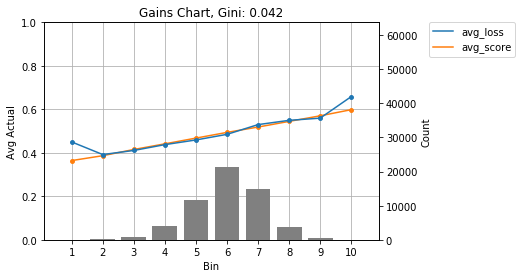

In [27]:
print("Train Gini: " + str(mpf.ks_gini(train_cc['team_100_win'], gbm_train_pred)))
print("Train accuracy: " + str(mpf.best_threshold(train_cc['team_100_win'], gbm_train_pred)))
print("Validation Gini: " + str(mpf.ks_gini(valid_cc['team_100_win'], gbm_validation_pred)))
print("Validation accuracy: " + str(mpf.best_threshold(valid_cc['team_100_win'], gbm_validation_pred)))
mpf.gains_chart(valid_cc['team_100_win'], gbm_validation_pred, return_table=False)

# 3. Word2Vec Encoding
### How it works
1. Take a corpus of words
2. Build a neural network on pairs of words (input_word, output_word)
3. input_word is a word in the corpus, output_word is a word that comes before or after it
4. Build a 1-hidden layer neural network on this dataset
5. The encoding is as follows: the input word is mapped to $(w_1, \ldots, w_k)$ -- the weights between that word and the hidden layer.

### Intuition on why it works
- Words have "context" -- their meaning depends on the meaning of the surrounding words
- This replaces a word with its "context"
- If two words have similar meaning, then they should appear in the same context.  Hence, they should have similar associated output_words.  This motivates the neural network to give them the same weights!
- This also preserves a certain relational meaning.  For example, in English male and king are related in the same way female and queen are.  In their encodings, one would expect $\vec(male) - \vec(female) \approx \vec(king) - \vec(queen)$.

### Applying the idea here
1. The corpus of words here are the champions on the winning team
2. Build a neural network on pairs of champions (input_champ, output_champ)
3. This is a pair of champions on the winning team in some match
4. Build a 1-hidden layer neural network on this dataset
5. The encoding is below!

In [28]:
weights = pd.read_csv('../data/interim/w2vec_weights.csv', index_col=0)
weights.head()

,0,1,2,3,4,5,6,7,8,9
Aatr,-0.089569,-0.084701,0.179452,-0.097304,-0.005922,0.150035,0.078898,-0.041835,-0.005252,-0.141666
Ahri,0.004493,-0.013360,0.123808,0.128273,0.005684,-0.127973,-0.112503,-0.131317,-0.209800,0.038655
Akal,-0.184045,-0.192603,0.025008,-0.035363,0.117062,0.155325,0.028803,0.065332,0.141745,0.147642
Alis,0.107325,-0.026489,0.103717,0.012351,0.010533,-0.121635,0.093064,0.184175,-0.181098,-0.049597
Amum,0.028132,-0.039928,0.195703,-0.108458,0.103810,0.036709,0.100832,0.179343,-0.086603,-0.154195


In [29]:
champs = dc.get_champs_four_letters()
champs = champs[champs != 'Pyke']
distances = pd.DataFrame(index=champs, columns=champs)
for c1 in champs:
    for c2 in champs:
        distances.loc[c1, c2] = np.sqrt(np.sum( (weights.loc[c1,:] - weights.loc[c2,:]) ** 2))

In [30]:
weights['closest_champ'] = ''
for c1 in champs:
    min_dist = np.min(distances[distances.index != c1].loc[:,c1])
    weights['closest_champ'][c1] = distances[c1][distances[c1] == min_dist].index[0]
weights.head()

,0,1,2,3,4,5,6,7,8,9,closest_champ
Aatr,-0.089569,-0.084701,0.179452,-0.097304,-0.005922,0.150035,0.078898,-0.041835,-0.005252,-0.141666,Vlad
Ahri,0.004493,-0.013360,0.123808,0.128273,0.005684,-0.127973,-0.112503,-0.131317,-0.209800,0.038655,Twis
Akal,-0.184045,-0.192603,0.025008,-0.035363,0.117062,0.155325,0.028803,0.065332,0.141745,0.147642,Trun
Alis,0.107325,-0.026489,0.103717,0.012351,0.010533,-0.121635,0.093064,0.184175,-0.181098,-0.049597,Dr.
Amum,0.028132,-0.039928,0.195703,-0.108458,0.103810,0.036709,0.100832,0.179343,-0.086603,-0.154195,Sona


In [31]:
weights.drop(['closest_champ'], inplace=True, axis=1)
train_w2v = train[lane_cols]
valid_w2v = valid[lane_cols]
for col in lane_cols:
    weights.columns = [col + '_' + str(x) for x in range(weights.shape[1])]
    train_w2v = pd.merge(train_w2v, weights, how='left', left_on=col, right_index=True)
    valid_w2v = pd.merge(valid_w2v, weights, how='left', left_on=col, right_index=True)
encoded_cols = [x + '_0' for x in lane_cols] + [x + '_1' for x in lane_cols] \
               + [x + '_2' for x in lane_cols] + [x + '_3' for x in lane_cols] + [x + '_4' for x in lane_cols] \
    + [x + '_5' for x in lane_cols] + [x + '_6' for x in lane_cols] + [x + '_7' for x in lane_cols] \
    + [x + '_8' for x in lane_cols] + [x + '_9' for x in lane_cols]
X_train = train_w2v[encoded_cols]
X_validation = valid_w2v[encoded_cols]
Y_train = train['team_100_win']
Y_validation = valid['team_100_win']

In [32]:
w2v_model = Sequential()
w2v_model.add(Dense(100, activation='sigmoid', input_shape=(X_train.shape[1],)))
w2v_model.add(Dense(50, activation='sigmoid'))
w2v_model.add(Dense(20, activation='sigmoid'))
w2v_model.add(Dense(10, activation='sigmoid'))
w2v_model.add(Dense(1))
w2v_model.compile(optimizer='adam', loss='mean_squared_error')
w2v_model.fit(X_train, Y_train)

Epoch 1/1
171284/171284 [==============================] - 10s 59us/step - loss: 0.2554


In [33]:
train_pred_w2v = w2v_model.predict(X_train)
print("Train ks and gini: " + str(mpf.ks_gini(Y_train, train_pred_w2v[:,0])))
print("Train accuracy: " + str(mpf.best_threshold(Y_train, train_pred_w2v[:,0])))
valid_pred_w2v = w2v_model.predict(X_validation)
print("Validation ks and gini: " + str(mpf.ks_gini(Y_validation, valid_pred_w2v[:,0])))
print("Validation accuracy: " + str(mpf.best_threshold(Y_validation, valid_pred_w2v[:,0])))

Train ks and gini: {'ks': 0.026386574517874295, 'gini': 0.036183247850304245}
Train accuracy: {'threshold': 0.55, 'accuracy': 0.520737488615399}
Validation ks and gini: {'ks': 0.026042542415181225, 'gini': 0.03542074563588488}
Validation accuracy: {'threshold': 0.55, 'accuracy': 0.5216751615784773}


# 4. Back to hot encoding
Previous hot encoding created 1410 columns (141 for every position).  What if we forget about position?  Then only need 282 indicators (141 for each team).  

Or go even simpler: 1 if it's on blue, -1 if it's on red.

In [34]:
X_train6 = train[lane_cols]
X_validation6 = valid[lane_cols]

for champ in champs:
    X_train6[champ] = 0
    X_validation6[champ] = 0
    for col in lane_cols:
        if col[0:3] == '100':
            X_train6[champ][X_train6[col] == champ] = 1
            X_validation6[champ][X_validation6[col] == champ] = 1
        else:
            X_train6[champ][X_train6[col] == champ] = -1
            X_validation6[champ][X_validation6[col] == champ] = -1
X_train6.drop(lane_cols, inplace=True, axis=1)
X_validation6.drop(lane_cols, inplace=True, axis=1)
print(X_train6.shape)

(171284, 140)


In [35]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(X_train6.shape[1],)))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train6, Y_train)

Epoch 1/1
171284/171284 [==============================] - 12s 70us/step - loss: 0.2482


In [36]:
train_pred = model.predict(X_train6)
print("Train ks and gini: " + str(mpf.ks_gini(Y_train, train_pred[:,0])))
print("Train accuracy: " + str(mpf.best_threshold(Y_train, train_pred[:,0])))
valid_pred = model.predict(X_validation6)
print("Validation ks and gini: " + str(mpf.ks_gini(Y_validation, valid_pred[:,0])))
print("Validation accuracy: " + str(mpf.best_threshold(Y_validation, valid_pred[:,0])))

Train ks and gini: {'ks': 0.05117562793263525, 'gini': 0.07187581881832743}
Train accuracy: {'threshold': 0.48, 'accuracy': 0.5503608042782747}
Validation ks and gini: {'ks': 0.05377502394906769, 'gini': 0.07331897703788423}
Validation accuracy: {'threshold': 0.49, 'accuracy': 0.5528698789694008}


# Ensemble

In [37]:
ensemble_formula = "team_100_win ~ simple_ohe_nn + w2v_nn + gbm_champ_class + rf2_paired_wr"
ensemble_train = pd.DataFrame({'team_100_win': train['team_100_win'], 'simple_ohe_nn': train_pred[:,0], 'w2v_nn': train_pred_w2v[:,0],
                              'gbm_champ_class': gbm_train_pred, 'rf2_paired_wr': train_pred_rf2})
ensemble_valid = pd.DataFrame({'team_100_win': valid['team_100_win'], 'simple_ohe_nn': valid_pred[:,0], 'w2v_nn': valid_pred_w2v[:,0],
                              'gbm_champ_class': gbm_validation_pred, 'rf2_paired_wr': valid_pred_rf2})

In [38]:
ensemble_logistic = smf.glm(formula=ensemble_formula, data=ensemble_train, family=sm.families.Binomial()).fit()
ensemble_logistic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           team_100_win   No. Observations:               171284
Model:                            GLM   Df Residuals:                   171279
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.1480e+05
Date:                Thu, 09 Aug 2018   Deviance:                   2.2961e+05
Time:                        21:52:30   Pearson chi2:                 1.71e+05
No. Iterations:                     5                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -9.0737      0.387    -23.426      0.000      -9.833      -8.315
simple_ohe_nn      -1.8135      0.131    -13.802      0.000      -2.071      -1.556
w2v_nn             -5.1009      0.734     -6.954      0.000      -6.539      -3.663
gbm_champ_class     3.0549      0.178     17.148      0.000       2.706       3.404
rf2_paired_wr      22.6211      0.342     66.080      0.000      21.950      23.292
===================================================================================
"""

Train Gini: {'ks': 0.08631444142390415, 'gini': 0.12119667642604824}
Train accuracy: {'threshold': 0.49, 'accuracy': 0.5848765792484996}
Validation Gini: {'ks': 0.04670698341879481, 'gini': 0.06546372347868389}
Validation accuracy: {'threshold': 0.53, 'accuracy': 0.5455134604942813}


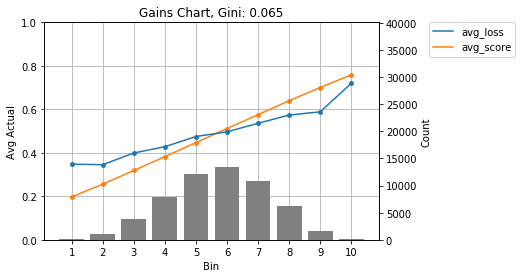

In [39]:
ensemble_train_pred = ensemble_logistic.predict(ensemble_train)
ensemble_valid_pred = ensemble_logistic.predict(ensemble_valid)
print("Train Gini: " + str(mpf.ks_gini(ensemble_train['team_100_win'], ensemble_train_pred)))
print("Train accuracy: " + str(mpf.best_threshold(ensemble_train['team_100_win'], ensemble_train_pred)))
print("Validation Gini: " + str(mpf.ks_gini(ensemble_valid['team_100_win'], ensemble_valid_pred)))
print("Validation accuracy: " + str(mpf.best_threshold(ensemble_valid['team_100_win'], ensemble_valid_pred)))
mpf.gains_chart(ensemble_valid['team_100_win'], ensemble_valid_pred, return_table=False)

Train Gini: {'ks': 0.0600591243116434, 'gini': 0.08552089032601388}
Train accuracy: {'threshold': 0.5, 'accuracy': 0.5596728240816422}
Validation Gini: {'ks': 0.057137358843027175, 'gini': 0.07705904849574532}
Validation accuracy: {'threshold': 0.5, 'accuracy': 0.5553045031790237}


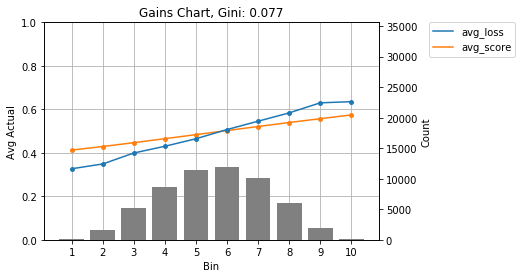

In [40]:
ensemble_train_pred = .45 * ensemble_train['simple_ohe_nn'] + .25 * ensemble_train['rf2_paired_wr'] + \
                      .15 * ensemble_train['w2v_nn'] + .15 * ensemble_train['gbm_champ_class'] 
ensemble_valid_pred = .45 * ensemble_valid['simple_ohe_nn'] + .25 * ensemble_valid['rf2_paired_wr'] + \
                      .15 * ensemble_valid['w2v_nn'] + .15 * ensemble_valid['gbm_champ_class'] 
print("Train Gini: " + str(mpf.ks_gini(ensemble_train['team_100_win'], ensemble_train_pred)))
print("Train accuracy: " + str(mpf.best_threshold(ensemble_train['team_100_win'], ensemble_train_pred)))
print("Validation Gini: " + str(mpf.ks_gini(ensemble_valid['team_100_win'], ensemble_valid_pred)))
print("Validation accuracy: " + str(mpf.best_threshold(ensemble_valid['team_100_win'], ensemble_valid_pred)))
mpf.gains_chart(ensemble_valid['team_100_win'], ensemble_valid_pred, return_table=False)

In [41]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')